In [1]:
%matplotlib inline
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import os
import seaborn as sns
import skimage
from skimage import io, transform
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms

In [2]:
print(os.listdir("D:chest_xray/chest_xray/"))

['test', 'train', 'val']


In [3]:
EPOCHS = 60
data_dir = "D:/chest_xray/chest_xray/"
TEST = 'test'
TRAIN = 'train'

In [4]:
def data_transforms(phase):
    if phase == TRAIN:
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.RandomRotation(degrees=15),
            transforms.RandomHorizontalFlip(),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])
        
    
    if phase == TEST:
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])        
        
    return transform

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms(x)) 
                  for x in [TRAIN, TEST]}

dataloaders = {TRAIN: torch.utils.data.DataLoader(image_datasets[TRAIN], batch_size = 16, shuffle=True),  
               TEST: torch.utils.data.DataLoader(image_datasets[TEST], batch_size = 1, shuffle=True)}

In [6]:
len(dataloaders[TRAIN])

408

In [7]:
dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, TEST]}
classes = image_datasets[TRAIN].classes
class_names = image_datasets[TRAIN].classes

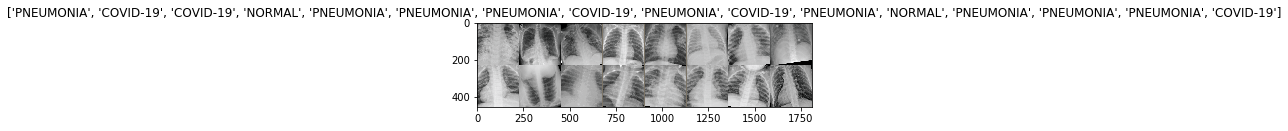

In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders[TRAIN]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [9]:
inputs, classes = next(iter(dataloaders[TRAIN]))

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_test_acc = 0.5
    
    for epoch in range(num_epochs):
        print("Epoch: {}/{}".format(epoch+1, num_epochs))
        print("="*10)
        
        for phase in [TRAIN, TEST]:
            if phase == TRAIN:
                scheduler.step()
                model.train()
            else:
                model.eval()
            # initialize the parameters
            # compute the loss
            # compute the gradients
            running_loss = 0.0
            running_corrects = 0
            for data in dataloaders[phase]:
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history when the phase is train
                with torch.set_grad_enabled(phase==TRAIN):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            if phase ==TRAIN:
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc.cpu().numpy().tolist())
            else:
                test_loss.append(epoch_loss)
                test_acc.append(epoch_acc.cpu().numpy().tolist())
            # deep copy the model
            if phase == 'test' and epoch_acc >= best_test_acc:
                best_test_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        print('Current Best Testing Acc: {:4f}'.format(best_test_acc))
        
    print('Best Testing Acc: {:4f}'.format(best_test_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [13]:
model_pre = models.resnet18()

In [14]:
for param in model_pre.parameters():
    param.required_grad = False

num_features = model_pre.fc.in_features
# Replace last layer
model_pre.fc = nn.Linear(num_features, len(class_names))

In [13]:
model_pre = model_pre.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_pre.parameters(), lr=0.01, momentum=0.9, weight_decay=0.01)
# Decay LR by a factor of 0.1 every 10 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [14]:
train_acc =[]
train_loss = []
test_acc = []
test_loss = []

In [15]:
model_pre = train_model(model_pre, criterion, optimizer, exp_lr_scheduler, num_epochs=EPOCHS)

Epoch: 1/60


D:\Anaconda\lib\site-packages\torch\optim\lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.4183 Acc: 0.8469
test Loss: 0.7107 Acc: 0.7380
Current Best Testing Acc: 0.737955
Epoch: 2/60
train Loss: 0.2405 Acc: 0.9128
test Loss: 0.9438 Acc: 0.7145
Current Best Testing Acc: 0.737955
Epoch: 3/60
train Loss: 0.2120 Acc: 0.9212
test Loss: 1.2434 Acc: 0.6733
Current Best Testing Acc: 0.737955
Epoch: 4/60
train Loss: 0.1893 Acc: 0.9288
test Loss: 0.7183 Acc: 0.7697
Current Best Testing Acc: 0.769683
Epoch: 5/60
train Loss: 0.1869 Acc: 0.9321
test Loss: 0.6521 Acc: 0.7638
Current Best Testing Acc: 0.769683
Epoch: 6/60
train Loss: 0.1935 Acc: 0.9332
test Loss: 0.6748 Acc: 0.7615
Current Best Testing Acc: 0.769683
Epoch: 7/60
train Loss: 0.1886 Acc: 0.9326
test Loss: 1.1705 Acc: 0.6592
Current Best Testing Acc: 0.769683
Epoch: 8/60
train Loss: 0.2057 Acc: 0.9323
test Loss: 0.8512 Acc: 0.7262
Current Best Testing Acc: 0.769683
Epoch: 9/60
train Loss: 0.1964 Acc: 0.9312
test Loss: 0.6994 Acc: 0.7556
Current Best Testing Acc: 0.769683
Epoch: 10/60
train Loss: 0.1396 Acc: 0.9

In [21]:
model_pre = torch.load("newbest.pkl")

In [16]:
def test_model():
    running_correct = 0.0
    running_total = 0.0
    true_labels = []
    pred_labels = []
    with torch.no_grad():
        for data in dataloaders[TEST]:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            true_labels.append(labels.item())
            outputs = model_pre(inputs)
            _, preds = torch.max(outputs.data, 1)
            pred_labels.append(preds.item())
            running_total += labels.size(0)
            running_correct += (preds == labels).sum().item()
        acc = running_correct/running_total
    return (true_labels, pred_labels, running_correct, running_total, acc)

In [22]:
true_labels, pred_labels, running_correct, running_total, acc = test_model()
print("Total Correct: {}, Total Test Images: {}".format(running_correct, running_total))
print("Test Accuracy: ", acc)

Total Correct: 741.0, Total Test Images: 851.0
Test Accuracy:  0.8707403055229143


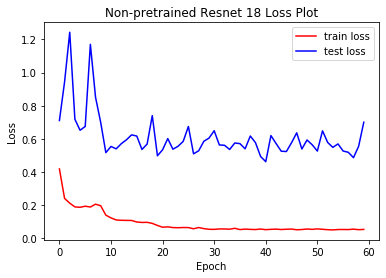

In [23]:
plt.plot(range(len(train_loss)),train_loss,color='red')
plt.plot(range(len(test_loss)),test_loss,color='blue')
plt.legend(['train loss','test loss'])
plt.title('Non-pretrained Resnet 18 Loss Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

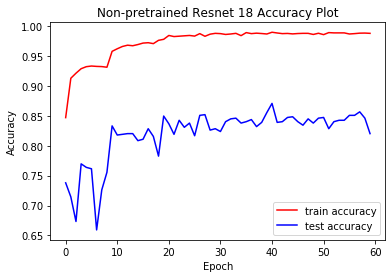

In [24]:
plt.plot(range(len(train_acc)),train_acc,color='red')
plt.plot(range(len(test_acc)),test_acc,color='blue')
plt.legend(['train accuracy','test accuracy'])
plt.title('Non-pretrained Resnet 18 Accuracy Plot')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()